In [1]:
%load_ext autoreload
%autoreload 2

### Load LRN models

In [3]:
import torch
model, transforms = torch.hub.load('harvard-visionlab/lrm-steering', 'alexnet_lrm3', pretrained=True, steering=True, force_reload=True)
print(model)

Downloading: "https://github.com/harvard-visionlab/lrm-steering/zipball/main" to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/main.zip


==> Loading weights for alexnet_lrm3, hash_id=63ab1b3b06
https://s3.us-east-1.wasabisys.com/visionlab-projects/dnn_feedback_dev/logs/set15/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps/28453e80-c5e5-4d76-bc81-99c5fade39ff/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps_final_weights-63ab1b3b06.pth
local_filename: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps_final_weights-63ab1b3b06.pth
<All keys matched successfully>
SteerableLRM(
  (feedforward): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 38

In [2]:
""" Cluster version of BigGAN Evol """
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import tqdm
import numpy as np
from os.path import join
import seaborn as sns
import matplotlib.pylab as plt
import torch
import torch.nn.functional as F
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from pytorch_pretrained_biggan import (BigGAN, truncated_noise_sample, one_hot_from_names, save_as_images)
from core.utils.CNN_scorers import TorchScorer
from core.utils.GAN_utils import BigGAN_wrapper, upconvGAN, loadBigGAN
from core.utils.grad_RF_estim import grad_RF_estimate, gradmap2RF_square
from core.utils.layer_hook_utils import get_module_names, layername_dict, register_hook_by_module_names, get_module_name_shapes
from core.utils.layer_hook_utils import featureFetcher, featureFetcher_module, featureFetcher_recurrent
from core.utils.Optimizers import CholeskyCMAES, HessCMAES, ZOHA_Sphere_lr_euclid
from core.utils.Optimizers import CholeskyCMAES, HessCMAES


In [4]:
from core.utils.dataset_utils import create_imagenet_valid_dataset

In [9]:
!echo $WORK_DIR

/n/holylabs/LABS/kempner_fellows/Users/binxuwang


In [8]:
!ls $WORK_DIR/Datasets/imagenet-valid/valid			       

ILSVRC2012_val_00000001.JPEG  ILSVRC2012_val_00025001.JPEG
ILSVRC2012_val_00000002.JPEG  ILSVRC2012_val_00025002.JPEG
ILSVRC2012_val_00000003.JPEG  ILSVRC2012_val_00025003.JPEG
ILSVRC2012_val_00000004.JPEG  ILSVRC2012_val_00025004.JPEG
ILSVRC2012_val_00000005.JPEG  ILSVRC2012_val_00025005.JPEG
ILSVRC2012_val_00000006.JPEG  ILSVRC2012_val_00025006.JPEG
ILSVRC2012_val_00000007.JPEG  ILSVRC2012_val_00025007.JPEG
ILSVRC2012_val_00000008.JPEG  ILSVRC2012_val_00025008.JPEG
ILSVRC2012_val_00000009.JPEG  ILSVRC2012_val_00025009.JPEG
ILSVRC2012_val_00000010.JPEG  ILSVRC2012_val_00025010.JPEG
ILSVRC2012_val_00000011.JPEG  ILSVRC2012_val_00025011.JPEG
ILSVRC2012_val_00000012.JPEG  ILSVRC2012_val_00025012.JPEG
ILSVRC2012_val_00000013.JPEG  ILSVRC2012_val_00025013.JPEG
ILSVRC2012_val_00000014.JPEG  ILSVRC2012_val_00025014.JPEG
ILSVRC2012_val_00000015.JPEG  ILSVRC2012_val_00025015.JPEG
ILSVRC2012_val_00000016.JPEG  ILSVRC2012_val_00025016.JPEG
ILSVRC2012_val_00000017.JPEG  ILSVRC2012_val_00025017.JP

In [11]:
INdataset = create_imagenet_valid_dataset(imgpix=224, normalize=True, rootdir='/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Datasets/imagenet-valid', )

In [15]:
from torch.utils.data import DataLoader
dataloader = DataLoader(INdataset, batch_size=128, shuffle=False, num_workers=4)

In [19]:
fetcher = featureFetcher(model,  input_size=(3, 224, 224), device="cuda", 
                         print_module=False, store_device="cpu", )
# fetcher.record(".feedforward.classifier.ReLU2",store_name="fc6_relu")
fetcher.record(".feedforward.classifier.ReLU5",store_name="fc7_relu")

In [23]:
dataloader = DataLoader(INdataset, batch_size=128, shuffle=False, num_workers=4)

max_iter = 4
layerkey = "fc7_relu"
scores_dyn_all = []
for imgs, _ in tqdm.tqdm(dataloader):
    imgs = imgs.cuda()
    scores_dyn = []
    for iforward in range(0, max_iter):
        with torch.no_grad():
            model(imgs, drop_state=True if iforward==0 else False, forward_passes=1)
        scores = fetcher[layerkey][:, :].cpu().detach()
        scores_dyn.append(scores)
    scores_dyn = torch.stack(scores_dyn, dim=1)
    scores_dyn_all.append(scores_dyn)

scores_dyn_all = torch.cat(scores_dyn_all, dim=0)

  0%|          | 0/391 [00:00<?, ?it/s]/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomRes

In [24]:
scores_dyn_all.shape # (N, max_iter, D)

torch.Size([50000, 4, 4096])

In [25]:
# define sparseness measure
def lifetime_sparseness(score_mat, dim=-1):
    N = score_mat.shape[dim]
    return (1 - (1/N) * (torch.norm(score_mat, p=1, dim=dim) / torch.norm(score_mat, p=2, dim=dim)))/(1-1/N)
    

In [39]:
def population_sparseness(score_mat, dim=-1):
    """Calculate population sparseness for a single stimulus.
    
    Parameters:
    activations (numpy array): 1D array of neural activations for a stimulus.
    
    Returns:
    float: Population sparseness score.
    """
    N = score_mat.shape[dim]
    squared_mean = score_mat.mean(dim=dim).pow(2)
    mean_squared = score_mat.pow(2).mean(dim=dim)
    sparseness = (1 - (squared_mean / mean_squared)) / (1 - 1/N)
    return sparseness

In [27]:
sparseness_mat = lifetime_sparseness(scores_dyn_all.cuda(), dim=0).cpu()

In [40]:
lifetime_sparseness_mat2 = population_sparseness(scores_dyn_all.cuda(), dim=0).cpu()

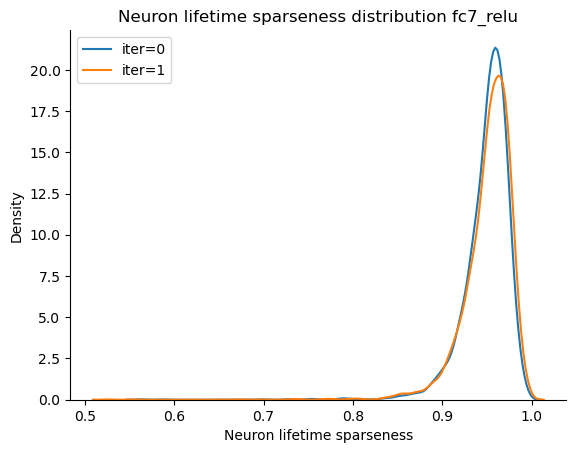

In [52]:
figh = plt.figure()
for iT in range(0, 2):
    sns.kdeplot(lifetime_sparseness_mat2[iT, :], label=f"iter={iT}")
plt.legend()
plt.xlabel("Neuron lifetime sparseness")
plt.title(f"Neuron lifetime sparseness distribution {layerkey}")
plt.show()


In [46]:
from scipy.stats import ttest_ind, ttest_rel
print(ttest_rel(lifetime_sparseness_mat2[0, :], lifetime_sparseness_mat2[1, :], nan_policy='omit'))
print(ttest_ind(lifetime_sparseness_mat2[0, :], lifetime_sparseness_mat2[1, :], nan_policy='omit'))
print(ttest_rel(lifetime_sparseness_mat2[0, :], lifetime_sparseness_mat2[2, :], nan_policy='omit'))
print(ttest_ind(lifetime_sparseness_mat2[0, :], lifetime_sparseness_mat2[2, :], nan_policy='omit'))

TtestResult(statistic=-13.482528700218468, pvalue=1.4378564442176355e-40, df=4094)
TtestResult(statistic=-2.2443676589818784, pvalue=0.02483535576914626, df=8188.0)
TtestResult(statistic=-43.10291109625785, pvalue=0.0, df=4094)
TtestResult(statistic=-4.131507243482503, pvalue=3.639795244676016e-05, df=8188.0)


In [37]:
from scipy.stats import ttest_ind, ttest_rel
ttest_rel(sparseness_mat[0, :], sparseness_mat[1, :], nan_policy='omit')

TtestResult(statistic=-19.785789192514326, pvalue=2.7450471524756004e-83, df=4094)

In [47]:
popul_sparseness_mat = lifetime_sparseness(scores_dyn_all.cuda(), dim=-1).cpu()
popul_sparseness_mat2 = population_sparseness(scores_dyn_all.cuda(), dim=-1).cpu()

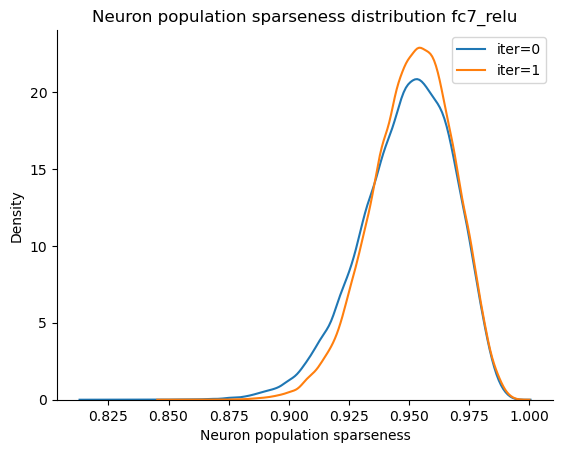

In [54]:
figh = plt.figure()
for iT in range(0, 2):
    sns.kdeplot(popul_sparseness_mat2[:, iT], label=f"iter={iT}")
plt.legend()
plt.xlabel("Neuron population sparseness")
plt.title(f"Neuron population sparseness distribution {layerkey}")
plt.show()

In [ ]:
print(ttest_rel(popul_sparseness_mat2[0, :], popul_sparseness_mat2[1, :], nan_policy='omit'))
print(ttest_ind(popul_sparseness_mat2[0, :], popul_sparseness_mat2[1, :], nan_policy='omit'))
print(ttest_rel(popul_sparseness_mat2[0, :], popul_sparseness_mat2[2, :], nan_policy='omit'))
print(ttest_ind(popul_sparseness_mat2[0, :], popul_sparseness_mat2[2, :], nan_policy='omit'))